In [1]:
import pandas as pd
import os
import seaborn as sns
import warnings
import scipy as sp
import pingouin as pg
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# Specify the directory path
directory = "air_quality"

# Get a list of all CSV files in the directory
csv_files = [file for file in os.listdir(directory) if file.endswith(".csv")]

# Initialize an empty dataframe
air_quality = pd.DataFrame()

# Iterate over each CSV file and concatenate them
for file in csv_files:
    file_path = os.path.join(directory, file)
    temp_df = pd.read_csv(file_path)
    air_quality = pd.concat([air_quality, temp_df])

# Print the concatenated dataframe
air_quality


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,35060,2017,2,28,19,11.0,32.0,3.0,24.0,400.0,72.0,12.5,1013.5,-16.2,0.0,NW,2.4,Wanshouxigong
35060,35061,2017,2,28,20,13.0,32.0,3.0,41.0,500.0,50.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Wanshouxigong
35061,35062,2017,2,28,21,14.0,28.0,4.0,38.0,500.0,54.0,10.8,1014.2,-13.3,0.0,NW,1.1,Wanshouxigong
35062,35063,2017,2,28,22,12.0,23.0,4.0,30.0,400.0,59.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Wanshouxigong


In [4]:
each_pollution = air_quality[['PM2.5','PM10','NO2','CO','SO2','O3']].copy()
each_pollution = each_pollution.dropna()
each_pollution

,PM2.5,PM10,NO2,CO,SO2,O3
0,4.0,4.0,7.0,300.0,4.0,77.0
1,8.0,8.0,7.0,300.0,4.0,77.0
2,7.0,7.0,10.0,300.0,5.0,73.0
3,6.0,6.0,11.0,300.0,11.0,72.0
4,3.0,3.0,12.0,300.0,12.0,72.0
...,...,...,...,...,...,...
35059,11.0,32.0,24.0,400.0,3.0,72.0
35060,13.0,32.0,41.0,500.0,3.0,50.0
35061,14.0,28.0,38.0,500.0,4.0,54.0
35062,12.0,23.0,30.0,400.0,4.0,59.0


KeyboardInterrupt: 

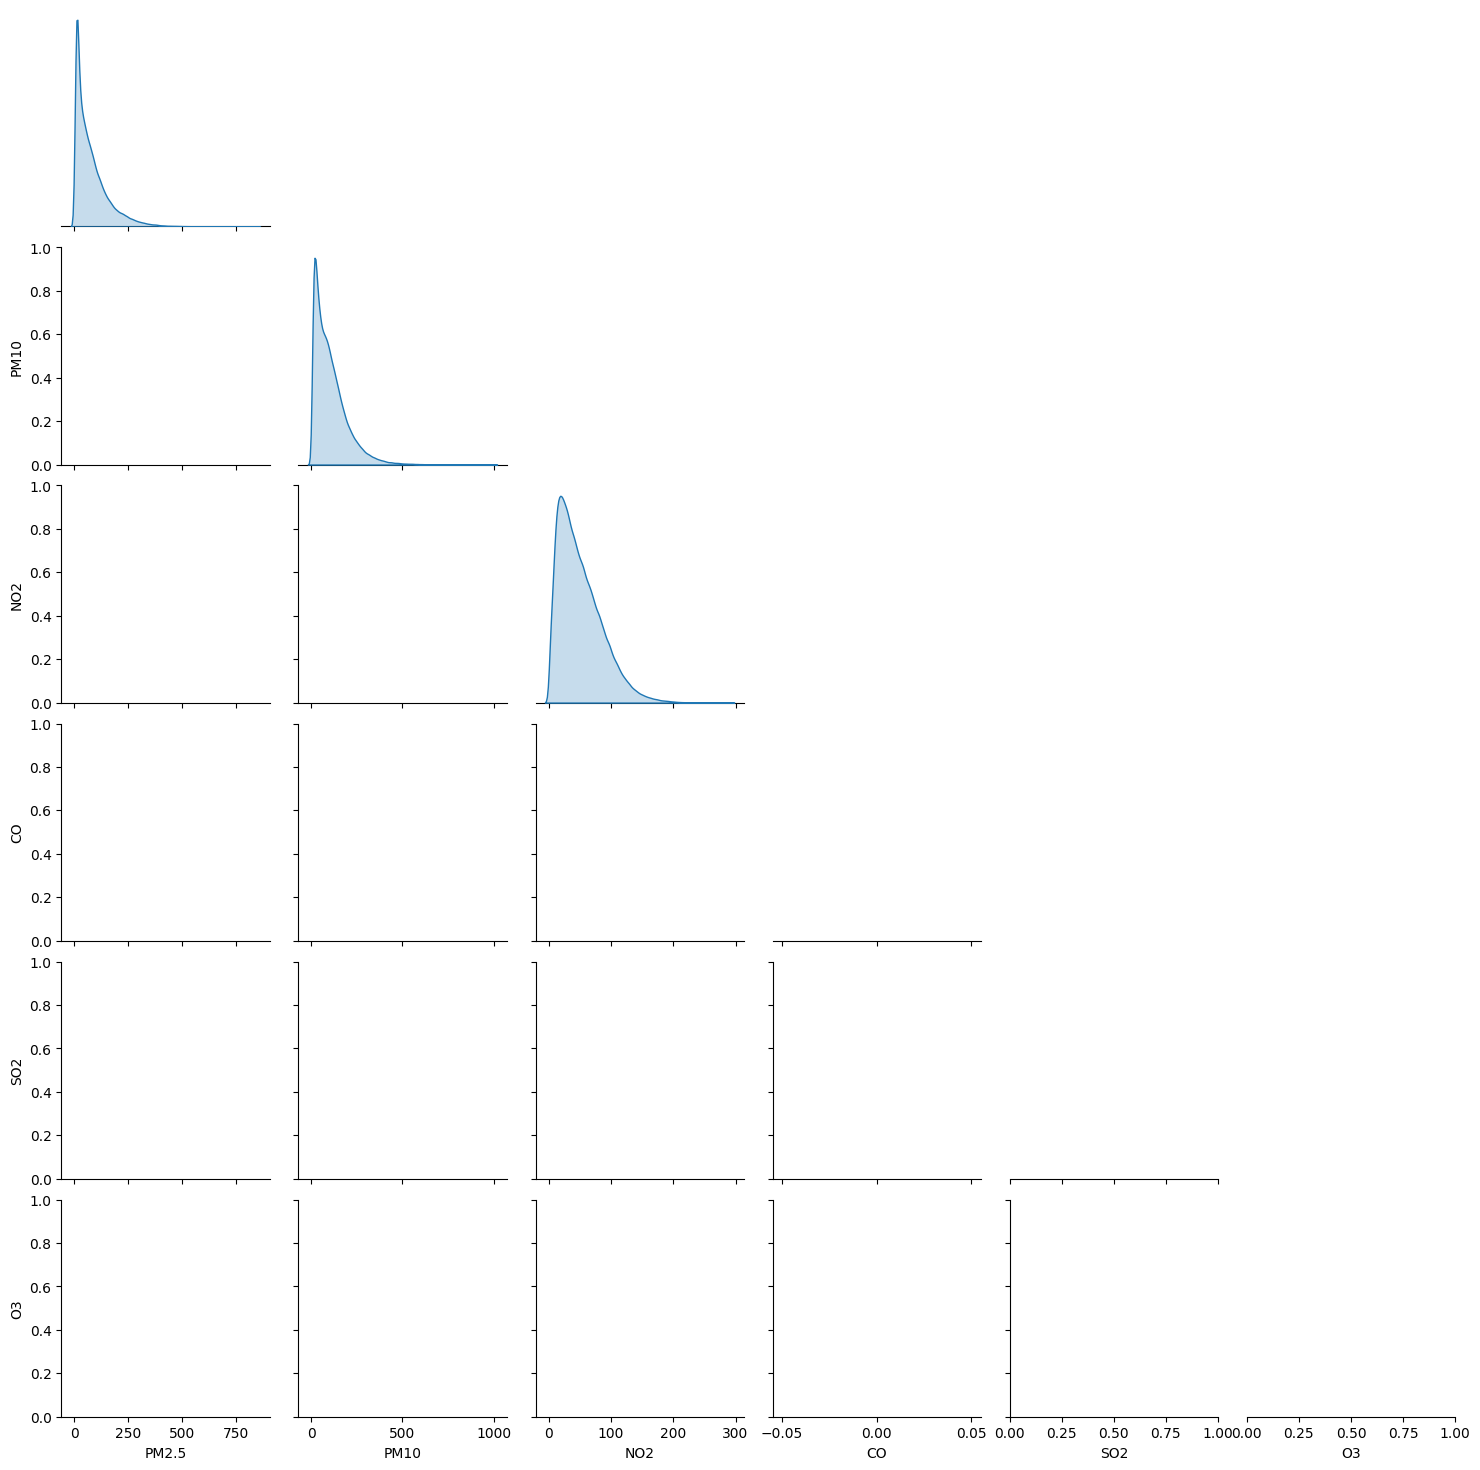

In [5]:
sns.pairplot(
    each_pollution, 
    kind='reg', 
    corner=True,
    diag_kind='kde',
    plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1, 's': 3}}
)
each_pollution.corr()

In [14]:
each_pollution.corr()

,PM2.5,PM10,NO2,CO,SO2,O3,prediction_of_PM2.5
PM2.5,1.000000,0.884317,0.670603,0.792143,0.481563,-0.151608,0.917178
PM10,0.884317,1.000000,0.653370,0.703608,0.465939,-0.114753,0.964172
NO2,0.670603,0.653370,1.000000,0.705461,0.500637,-0.476758,0.731159
CO,0.792143,0.703608,0.705461,1.000000,0.534377,-0.315331,0.863674
SO2,0.481563,0.465939,0.500637,0.534377,1.000000,-0.166469,0.529767
O3,-0.151608,-0.114753,-0.476758,-0.315331,-0.166469,1.000000,-0.165298
prediction_of_PM2.5,0.917178,0.964172,0.731159,0.863674,0.529767,-0.165298,1.000000


可以看出PM2.5与O3相关性较小

In [6]:
# 列出你想要控制的变量
all_variables = ['PM10', 'SO2', 'NO2', 'CO', 'O3']

# 对每个控制变量进行偏相关分析
for variable in all_variables:
    # 创建一个不包含当前 y 变量的控制变量列表
    control_variables = [v for v in all_variables if v != variable]
    
    partial_corr = pg.partial_corr(data=each_pollution, x='PM2.5', y=variable, covar=control_variables)
    print(f"Partial correlation of PM2.5 with {variable} controlling for {control_variables}:\n", partial_corr, "\n")

Partial correlation of PM2.5 with PM10 controlling for ['SO2', 'NO2', 'CO', 'O3']:
               n         r        CI95%  p-val
pearson  383980  0.705566  [0.7, 0.71]    0.0 

Partial correlation of PM2.5 with SO2 controlling for ['PM10', 'NO2', 'CO', 'O3']:
               n         r           CI95%         p-val
pearson  383980 -0.013217  [-0.02, -0.01]  2.607388e-16 

Partial correlation of PM2.5 with NO2 controlling for ['PM10', 'SO2', 'CO', 'O3']:
               n         r         CI95%  p-val
pearson  383980  0.082643  [0.08, 0.09]    0.0 

Partial correlation of PM2.5 with CO controlling for ['PM10', 'SO2', 'NO2', 'O3']:
               n         r         CI95%  p-val
pearson  383980  0.457133  [0.45, 0.46]    0.0 

Partial correlation of PM2.5 with O3 controlling for ['PM10', 'SO2', 'NO2', 'CO']:
               n         r        CI95%  p-val
pearson  383980  0.106061  [0.1, 0.11]    0.0 



In [22]:
# 定义因变量和自变量

X = each_pollution[['PM10', 'SO2','CO', 'NO2', 'O3']]
y = each_pollution['PM2.5']

# 添加截距项
X = sm.add_constant(X)

# 进行多元线性回归
model = sm.OLS(y, X)
results = model.fit()

# 打印回归结果
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  PM2.5   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                 4.069e+05
Date:                Tue, 26 Dec 2023   Prob (F-statistic):               0.00
Time:                        20:18:20   Log-Likelihood:            -1.8750e+06
No. Observations:              383980   AIC:                         3.750e+06
Df Residuals:                  383974   BIC:                         3.750e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.2937      0.136   -119.725      0.0

In [23]:
# 获取 R² 值
r_squared = results.rsquared
print(f"R-squared: {r_squared}")

# 获取调整 R² 值
r_squared_adj = results.rsquared_adj
print(f"Adjusted R-squared: {r_squared_adj}")

# 获取标准估计误差
standard_errors = results.bse
print(f"Standard Errors: {standard_errors}")

R-squared: 0.8412436033561908
Adjusted R-squared: 0.8412415360756373
Standard Errors: const    0.136093
PM10     0.000882
SO2      0.002947
CO       0.000073
NO2      0.002493
O3       0.001093
dtype: float64


从上述结果可以看出，我们的模型可以解释84.1%的观测结果。

In [24]:
# 获取 F 统计量的值
f_value = results.fvalue
print(f"F-statistic: {f_value}")

# 获取 F 统计量的 p 值
f_pvalue = results.f_pvalue
print(f"P-value of F-statistic: {f_pvalue}")

F-statistic: 406932.4804339291
P-value of F-statistic: 0.0


In [25]:
# 获取 t 统计量的值
t_values = results.tvalues
print(f"T-statistics: {t_values}")

# 获取 t 统计量的 p 值
p_values = results.pvalues
print(f"P-values: {p_values}")

T-statistics: const   -119.725031
PM10     616.964013
SO2       -8.190588
CO       318.490576
NO2       51.386127
O3        66.094190
dtype: float64
P-values: const    0.000000e+00
PM10     0.000000e+00
SO2      2.607388e-16
CO       0.000000e+00
NO2      0.000000e+00
O3       0.000000e+00
dtype: float64


由此可见各个变量与PM2.5均有显著的线性相关性。

Regression equation: y = -16.293680832737138 + 0.544330183703221*x1 + -0.02414067923065298*x2 + 0.02322751905378704*x3 + 0.12811275645793688*x4 + 0.07226605462701785*x5


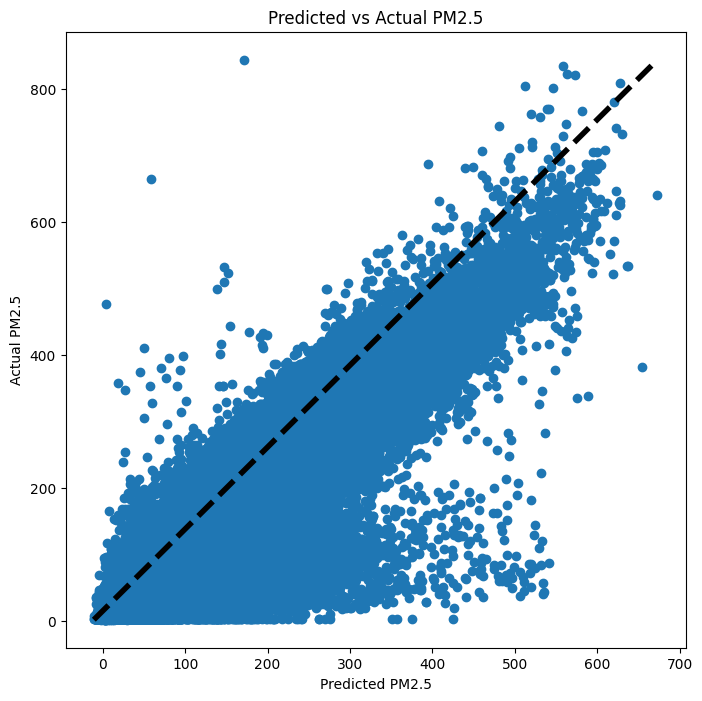

In [27]:
each_pollution['prediction_of_PM2.5'] = results.predict(X)

x = each_pollution['prediction_of_PM2.5']
y = each_pollution['PM2.5']

# 创建一个新的图形
plt.figure(figsize=(8, 8))

# 绘制散点图
plt.scatter(x, y)

# 添加对角线
plt.plot([x.min(), x.max()], [y.min(), y.max()], 'k--', lw=4)

# 设置标题和标签
plt.title('Predicted vs Actual PM2.5')
plt.xlabel('Predicted PM2.5')
plt.ylabel('Actual PM2.5')

# 显示图形
plt.show()




In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 获取预测值和实际值
predictions = each_pollution['prediction_of_PM2.5']
actual = each_pollution['PM2.5']

# 计算 MSE
mse = mean_squared_error(actual, predictions)
print(f"Mean Squared Error (MSE): {mse}")

# 计算 RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# 计算 MAE
mae = mean_absolute_error(actual, predictions)
print(f"Mean Absolute Error (MAE): {mae}")


Mean Squared Error (MSE): 1020.8039655942254
Root Mean Squared Error (RMSE): 31.950022935738644
Mean Absolute Error (MAE): 20.62084684374623
